# Dash web app with map of Copenhagen with average income for each district

In [1]:
# Import modules
from jupyter_dash import JupyterDash
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import geopandas as gdp
import matplotlib.pyplot as plt
import contextily as ctx

In [2]:
# Import geo data
geo_df = gdp.read_file('districts/bydel.shp')

In [3]:
# Select relevant columns
geo_df = (geo_df
          .loc[:, ['navn', 'geometry']]
         )

# Change district name 
geo_df['navn'].replace({"Vesterbro-Kongens Enghave": "Vesterbro/Kongens Enghave"}, inplace=True)


In [4]:
# Look at the geo data
geo_df

,navn,geometry
0,Vanløse,"POLYGON ((12.49820 55.68552, 12.49807 55.68545..."
1,Bispebjerg,"POLYGON ((12.53830 55.72644, 12.53846 55.72640..."
2,Amager Vest,"POLYGON ((12.58271 55.66850, 12.58661 55.66783..."
3,Nørrebro,"POLYGON ((12.53704 55.69653, 12.53736 55.69661..."
4,Brønshøj-Husum,"POLYGON ((12.46894 55.69975, 12.46698 55.70024..."
5,Indre By,"MULTIPOLYGON (((12.72897 55.70386, 12.72899 55..."
6,Amager Øst,"POLYGON ((12.63082 55.67057, 12.63094 55.67049..."
7,Østerbro,"POLYGON ((12.59777 55.70348, 12.59700 55.70331..."
8,Vesterbro/Kongens Enghave,"POLYGON ((12.54553 55.63972, 12.54677 55.63900..."
9,Valby,"POLYGON ((12.52434 55.66666, 12.52449 55.66668..."


In [5]:
# Import income data
df_income = pd.read_csv('data/avg-income-districts-cph.csv', encoding = "ISO-8859-1", sep=';')

In [6]:
# Look at the data
df_income.head()

,district,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,District - Indre By,326988,345261,351173,362277,380598,398474,409033,422123,431152,457727
1,District - Østerbro,306248,309680,318321,325432,332546,345110,354481,363637,376002,392504
2,District - Nørrebro,232740,236408,240723,245021,251550,259959,266450,273494,281437,292139
3,District - Vesterbro/Kongens Enghave,267431,272759,281126,286305,295440,304436,312523,323748,337283,350601
4,District - Valby,274896,278852,284216,287020,292458,300856,304855,311108,320160,331929


In [7]:
# Clean district rows
df_income['district'] = df_income['district'].str[11:]

In [8]:
# Pivot data from wide to long format
df_income_long = (df_income.melt(id_vars = 'district', 
                                 var_name = 'year', 
                                 value_name = 'avg_income')) # https://towardsdatascience.com/reshape-pandas-dataframe-with-melt-in-python-tutorial-and-visualization-29ec1450bb02

In [9]:
df_income_long

,district,year,avg_income
0,Indre By,2010,326988
1,Østerbro,2010,306248
2,Nørrebro,2010,232740
3,Vesterbro/Kongens Enghave,2010,267431
4,Valby,2010,274896
...,...,...,...
95,Vanløse,2019,350027
96,Brønshøj-Husum,2019,316011
97,Bispebjerg,2019,278527
98,Amager Øst,2019,331012


In [10]:
# Join the two data frames
df_income_geo = (df_income_long
                .merge(geo_df, 
                       left_on = 'district', 
                       right_on = 'navn', 
                       how = 'left')
                .drop(['navn'], axis = 1)
                )

In [11]:
# Look at the geo data
df_income_geo

,district,year,avg_income,geometry
0,Indre By,2010,326988,"MULTIPOLYGON (((12.72897 55.70386, 12.72899 55..."
1,Østerbro,2010,306248,"POLYGON ((12.59777 55.70348, 12.59700 55.70331..."
2,Nørrebro,2010,232740,"POLYGON ((12.53704 55.69653, 12.53736 55.69661..."
3,Vesterbro/Kongens Enghave,2010,267431,"POLYGON ((12.54553 55.63972, 12.54677 55.63900..."
4,Valby,2010,274896,"POLYGON ((12.52434 55.66666, 12.52449 55.66668..."
...,...,...,...,...
95,Vanløse,2019,350027,"POLYGON ((12.49820 55.68552, 12.49807 55.68545..."
96,Brønshøj-Husum,2019,316011,"POLYGON ((12.46894 55.69975, 12.46698 55.70024..."
97,Bispebjerg,2019,278527,"POLYGON ((12.53830 55.72644, 12.53846 55.72640..."
98,Amager Øst,2019,331012,"POLYGON ((12.63082 55.67057, 12.63094 55.67049..."


In [12]:
# Convert to geo dataframe
df_income_geo = gdp.GeoDataFrame(df_income_geo)

In [13]:
# Filter year
df_income_geo_2019 = df_income_geo[df_income_geo['year'] == '2019']

df_income_geo_2019

,district,year,avg_income,geometry
90,Indre By,2019,457727,"MULTIPOLYGON (((12.72897 55.70386, 12.72899 55..."
91,Østerbro,2019,392504,"POLYGON ((12.59777 55.70348, 12.59700 55.70331..."
92,Nørrebro,2019,292139,"POLYGON ((12.53704 55.69653, 12.53736 55.69661..."
93,Vesterbro/Kongens Enghave,2019,350601,"POLYGON ((12.54553 55.63972, 12.54677 55.63900..."
94,Valby,2019,331929,"POLYGON ((12.52434 55.66666, 12.52449 55.66668..."
95,Vanløse,2019,350027,"POLYGON ((12.49820 55.68552, 12.49807 55.68545..."
96,Brønshøj-Husum,2019,316011,"POLYGON ((12.46894 55.69975, 12.46698 55.70024..."
97,Bispebjerg,2019,278527,"POLYGON ((12.53830 55.72644, 12.53846 55.72640..."
98,Amager Øst,2019,331012,"POLYGON ((12.63082 55.67057, 12.63094 55.67049..."
99,Amager Vest,2019,346303,"POLYGON ((12.58271 55.66850, 12.58661 55.66783..."


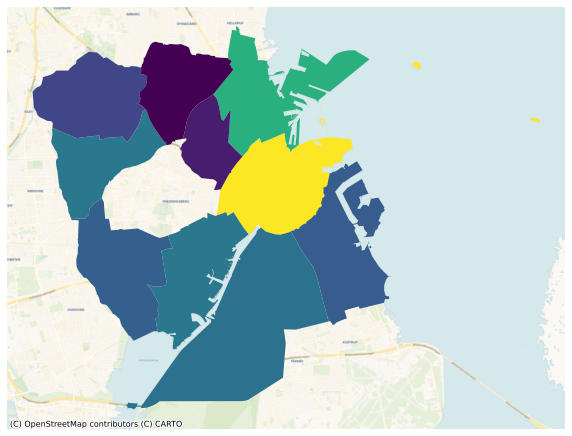

In [14]:
# Plot the geospatial data
df_income_geo_2019 = df_income_geo_2019.to_crs(epsg=3857) # Transform geometries to another coordinate reference system

ax = df_income_geo_2019.plot(column = 'avg_income', figsize=(10, 10)) # plot the district polygons using the geopandas plot method

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager) # add background map

ax.set_axis_off() # remove axes